In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
DATADRIVE = '/home/jupyter/data/'

## Stuff

In [ ]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-01'),
    first_days=5,
    ensemble_mode='stack',
    idx_stride=8
)

In [5]:
X, y = ds_train[0]
X.shape, y.shape

((10, 16, 16), (1, 128, 128))

In [105]:
href = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/20200101_12.nc').load()

In [107]:
(href.diff('lead_time') < 0).sum()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2020-01-01T12:00:00
    surface  float64 0.0
Data variables:
    tp       int64 4312908

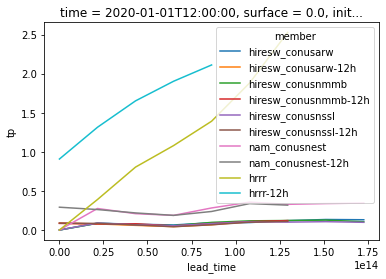

In [109]:
href.tp.mean(('lat', 'lon')).plot(hue='member');

In [203]:
href = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/2020*_12.nc')

In [204]:
href

<xarray.Dataset>
Dimensions:     (init_time: 364, lat: 750, lead_time: 9, lon: 1376, member: 10)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-31...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] dask.array<chunksize=(1, 9), meta=np.ndarray>
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-31...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
Data variables:
    tp          (member, init_time, lat, lon, lead_time) float32 dask.array<chunksize=(10, 1, 750, 1376, 9), meta=np.ndarray>

/opt/conda/envs/ilan/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


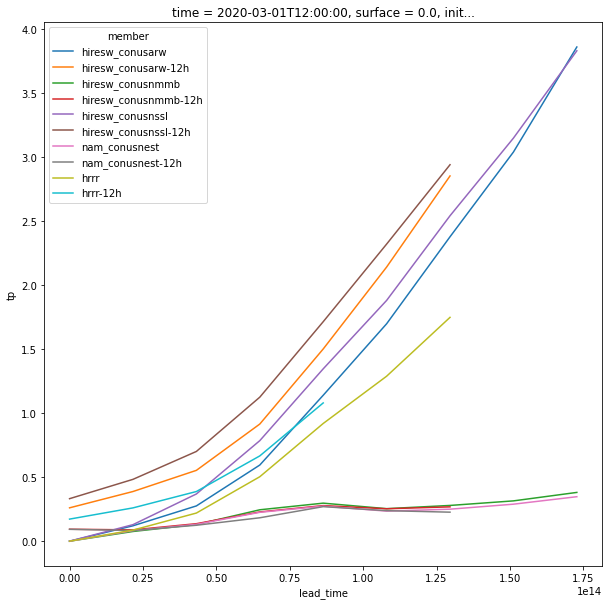

In [212]:
plt.figure(figsize=(10, 10))
href.tp.sel(init_time='2020-03-01T12').mean(('lat', 'lon')).plot(hue='member');

In [216]:
a = href.tp.isel(lead_time=-2).sel(member='hiresw_conusnmmb').mean(('lat', 'lon')).load()

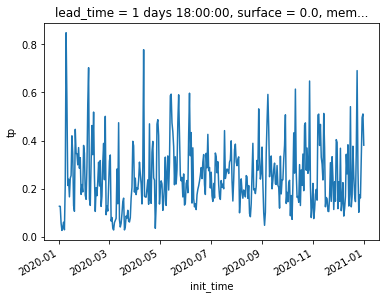

In [217]:
a.plot()

In [207]:
a = href.tp.isel(lead_time=-2).sel(member='hiresw_conusarw').mean(('lat', 'lon')).load()

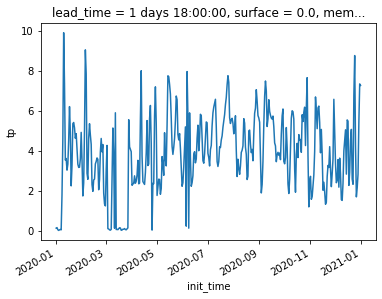

In [208]:
a.plot()

In [172]:
raw = xr.open_dataset('/home/jupyter/data/hiresw_conusarw/raw/total_precipitation/20200101_12.nc')

In [173]:
raw.tp

<xarray.DataArray 'tp' (init_time: 1, lead_time: 8, y: 1059, x: 1799)>
[15241128 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        (lead_time) timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  (lead_time) datetime64[ns] ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00
Dimensions without coordinates: y, x

In [168]:
raw = xr.open_dataset('/home/jupyter/data/hiresw_conusarw/raw/total_precipitation/20200109_12.nc')

In [171]:
raw.tp

<xarray.DataArray 'tp' (init_time: 1, lead_time: 8, y: 1059, x: 1799)>
array([[[[ 0.      , ...,  0.      ],
         ...,
         [ 3.635908, ...,  0.      ]],

        ...,

        [[ 0.250752, ...,  5.015045],
         ...,
         [11.785357, ...,  4.638917]]]], dtype=float32)
Coordinates:
    time        datetime64[ns] ...
    step        (lead_time) timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  (lead_time) datetime64[ns] ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * init_time   (init_time) datetime64[ns] 2020-01-09T12:00:00
Dimensions without coordinates: y, x

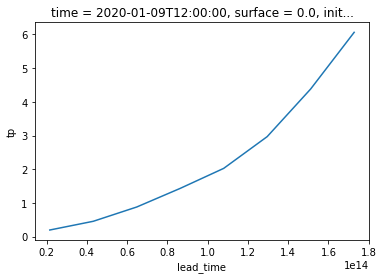

In [169]:
raw.tp.mean(('x', 'y')).plot()

In [184]:
!wget https://data.nssl.noaa.gov/thredds/fileServer/FRDD/HREF/2020/20200101/hiresw_conusarw_2020010100f024.grib2 -O hiresw_conusarw_2020010100f024.grib2

--2021-09-28 08:26:37--  https://data.nssl.noaa.gov/thredds/fileServer/FRDD/HREF/2020/20200101/hiresw_conusarw_2020010100f024.grib2
Resolving data.nssl.noaa.gov (data.nssl.noaa.gov)... 140.172.25.117
Connecting to data.nssl.noaa.gov (data.nssl.noaa.gov)|140.172.25.117|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 17863643 (17M) [application/octet-stream]
Saving to: ‘hiresw_conusarw_2020010100f024.grib2’

hiresw_conusarw_202 100%[===================>]  17.04M  37.9MB/s    in 0.4s    

2021-09-28 08:26:37 (37.9 MB/s) - ‘hiresw_conusarw_2020010100f024.grib2’ saved [17863643/17863643]



In [ ]:
!wget https://data.nssl.noaa.gov/thredds/fileServer/FRDD/HREF/2020/20200110/nam_conusnest_2020011000f024.grib2 -O  nam_conusnest_2020011000f024.grib2

In [83]:
grib1 = xr.open_dataset(
    'hiresw_conusarw_2020010100f024.grib2', 
    engine='cfgrib', 
    filter_by_keys={'stepType': 'accum', 'typeOfLevel': 'surface'}
).tp.rename({'latitude': 'lat', 'longitude': 'lon'})

grib2 = xr.open_dataset(
    'hiresw_conusarw_2020011000f024.grib2', 
    engine='cfgrib', 
    filter_by_keys={'stepType': 'accum', 'typeOfLevel': 'surface'}
).tp.rename({'latitude': 'lat', 'longitude': 'lon'})

In [27]:
grib2 = xr.open_dataset(
    'nam_conusnest_2020011000f024.grib2', 
    engine='cfgrib', 
    filter_by_keys={'stepType': 'accum', 'typeOfLevel': 'surface'}
).tp.rename({'latitude': 'lat', 'longitude': 'lon'})

In [28]:
grib2

<xarray.DataArray 'tp' (y: 1059, x: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             228228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Total Precipitation
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    long_name:                                Total Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [84]:
grib1

<xarray.DataArray 'tp' (y: 1059, x: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             228228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Total Precipitation
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    long_name:                                Total Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [198]:
grib2

<xarray.DataArray 'tp' (y: 1059, x: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             228228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Total Precipitation
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    long_name:                                Total Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [199]:
grib1.mean()

<xarray.DataArray 'tp' ()>
array(0.05667612, dtype=float32)
Coordinates:
    time        datetime64[ns] 2020-01-01
    step        timedelta64[ns] 1 days
    surface     float64 0.0
    valid_time  datetime64[ns] 2020-01-02

In [200]:
grib2.mean()

<xarray.DataArray 'tp' ()>
array(2.5609791, dtype=float32)
Coordinates:
    time        datetime64[ns] 2020-01-10
    step        timedelta64[ns] 1 days
    surface     float64 0.0
    valid_time  datetime64[ns] 2020-01-11

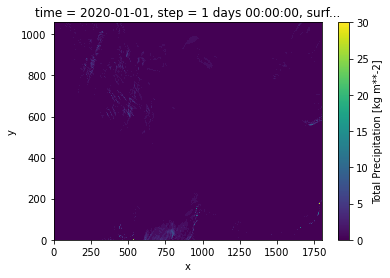

In [201]:
grib1.plot()

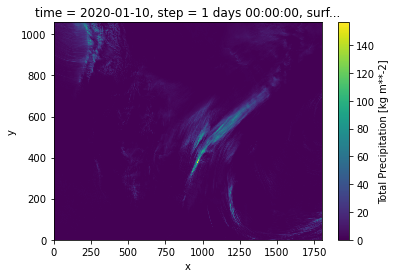

In [202]:
grib2.plot()

## 

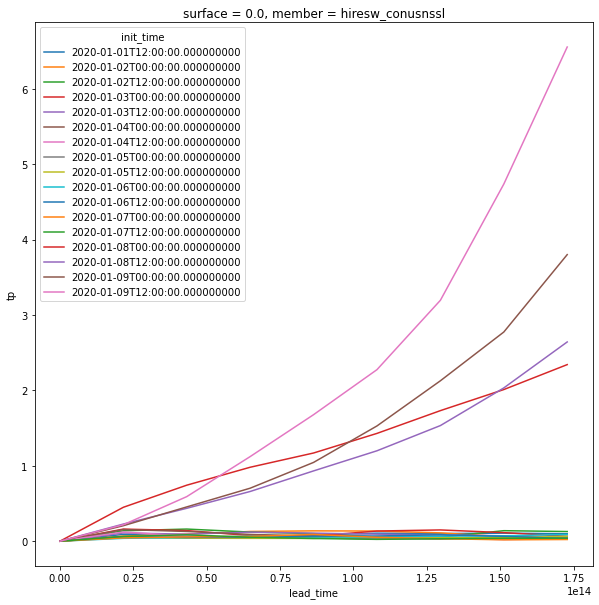

In [141]:
plt.figure(figsize=(10, 10))
href.tp.sel(member='hiresw_conusnssl').mean(('lat', 'lon')).plot(hue='init_time')

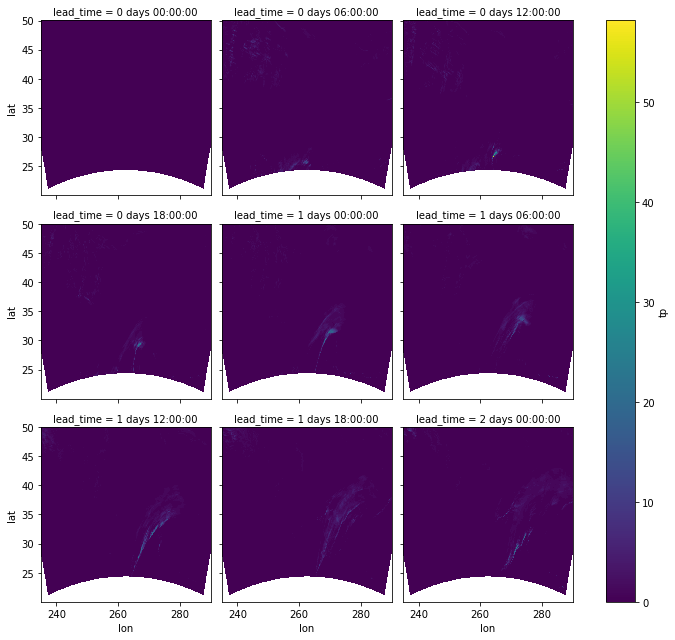

In [139]:
href.tp.isel(init_time=0).sel(member='hiresw_conusarw').plot(col='lead_time', col_wrap=3)

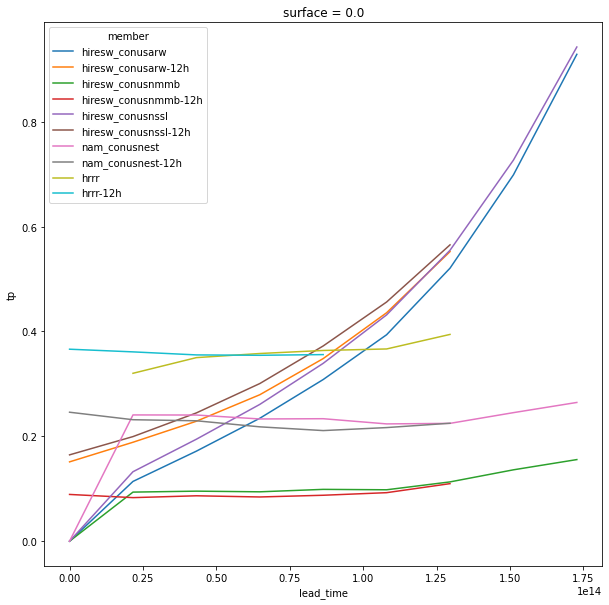

In [127]:
plt.figure(figsize=(10, 10))
href.tp.mean(('lat', 'lon', 'init_time')).plot(hue='member');

In [128]:
href_old = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/2020010*.nc').load()

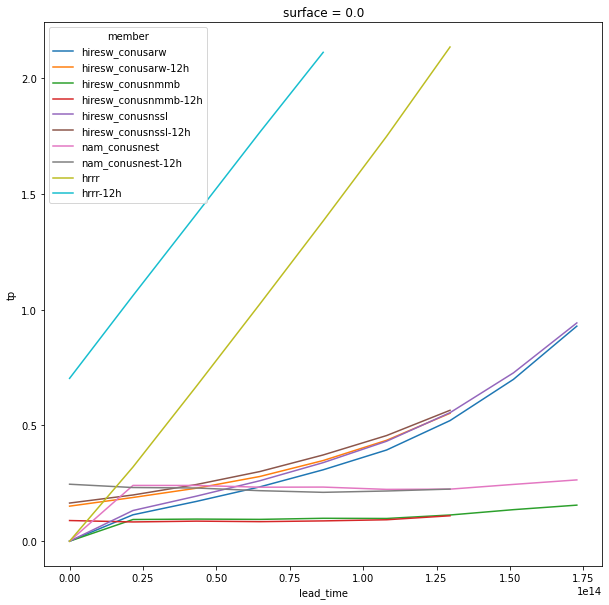

In [130]:
plt.figure(figsize=(10, 10))
href_old.tp.mean(('lat', 'lon', 'init_time')).plot(hue='member');

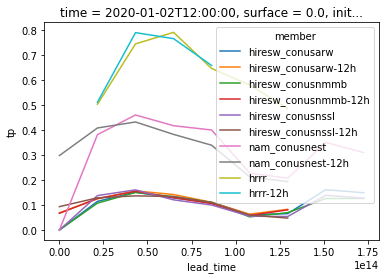

In [115]:
href.tp.mean(('lat', 'lon')).plot(hue='member');

In [119]:
href.close()

In [117]:
href

<xarray.Dataset>
Dimensions:     (init_time: 1, lat: 750, lead_time: 9, lon: 1376, member: 10)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        datetime64[ns] 2020-01-02T12:00:00
    surface     float64 0.0
    valid_time  (lead_time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-01-04...
  * init_time   (init_time) datetime64[ns] 2020-01-02T12:00:00
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
Data variables:
    tp          (member, init_time, lat, lon, lead_time) float32 0.0 0.0 ... nan

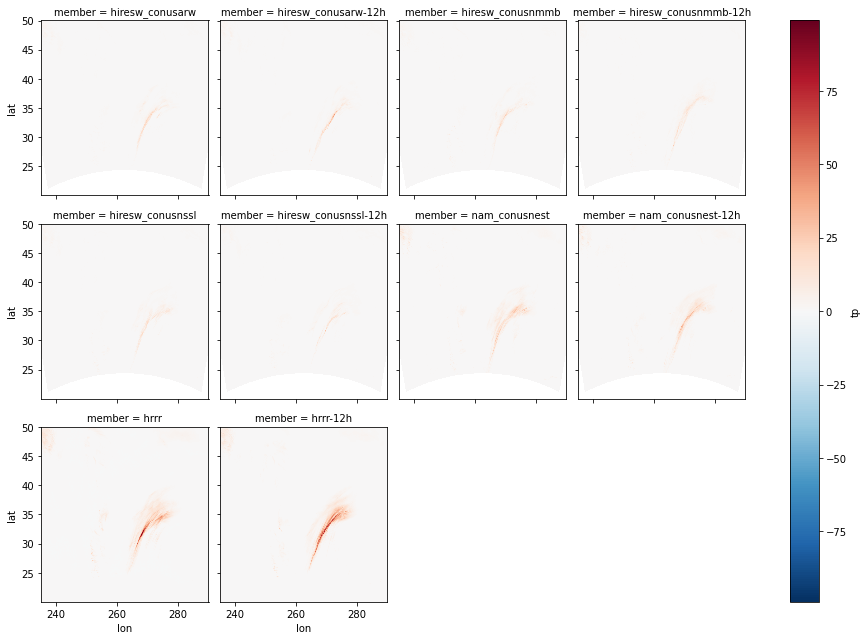

In [118]:
href.tp.isel(lead_time=2).plot(col='member', col_wrap=4)

In [89]:
b = xr.open_dataset('/home/jupyter/data/nam_conusnest/raw/total_precipitation/20200112_12.nc')

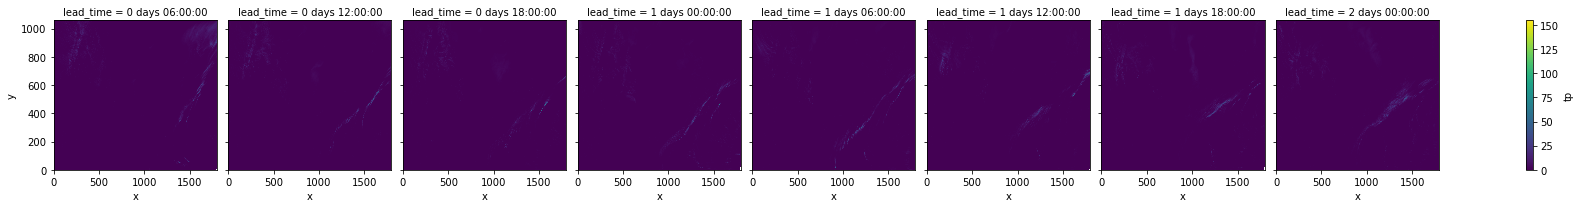

In [96]:
b.tp.isel(init_time=0).plot(col='lead_time')

In [11]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [19]:
href_overlap_times = np.intersect1d(
    ds_train.overlap_times, 
    href.valid_time
)

In [21]:
ds_train.mrms

<xarray.DataArray 'tp' (time: 9, lat: 750, lon: 1376)>
array([[[0.00000000e+00, 1.33129200e-04, 6.65645998e-05, ...,
         6.92271802e-03, 3.72761779e-03, 1.79724436e-03],
        [0.00000000e+00, 0.00000000e+00, 5.32516798e-04, ...,
         9.05278569e-03, 5.12547398e-03, 2.13006719e-03],
        [0.00000000e+00, 2.66258399e-04, 5.99081373e-04, ...,
         8.18744578e-03, 5.99081389e-03, 2.79571302e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05T12:00:00
  * lat        (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon        (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0
    lead_time  timedelta64[ns] 12:00:00

In [20]:
href.sel(valid_time=href_overlap_times)

<xarray.DataArray 'tp' (member: 10, valid_time: 8, lat: 750, lon: 1376)>
dask.array<getitem, shape=(10, 8, 750, 1376), dtype=float32, chunksize=(10, 1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    time        (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-02 ... 2020-01-05T12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'

## New stuff

### Def

In [4]:
class TiggeMRMSHREFDataset(TiggeMRMSDataset):
    def __init__(self, href_dir, **kwargs):
        self.href = xr.open_mfdataset(href_dir)
        self.href = self.href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
        self.href['valid_time'] = self.href.init_time + self.href.lead_time
        self.href = self.href.swap_dims({'init_time': 'valid_time'})
        
        
        super().__init__(**kwargs)
        self.href.load()
        
    def _create_rqmask(self, rq_fn):
        """Coarsen radar mask to patch and check for full coverage"""
        rq = xr.open_dataarray(rq_fn).load()
        # Account for padding
#         rq = rq.isel(lat=slice(self.pad_mrms, -self.pad_mrms or None), lon=slice(self.pad_mrms, -self.pad_mrms or None))
#         self.rqmask = rq.coarsen(lat=self.patch_mrms, lon=self.patch_mrms, boundary='trim').min() >= 0
        # RQ mask checks for validity of patch indexed by lower left coordinate
        # Note: lat is oriented reversele, so in "real" coords it's the upper left corner
        self.rqmask = (rq[::-1, ::-1].rolling(
            {'lat': self.patch_mrms}, min_periods=1
        ).min().rolling(
            {'lon': self.patch_mrms}, min_periods=1
        ).min() >=0)[::-1, ::-1]
        
        hrefmask = np.isfinite(self.href.isel(valid_time=0).load()).mean(('member')) == 1
        hrefmask = hrefmask.assign_coords(
            {'lat': self.rqmask.lat.values, 'lon': self.rqmask.lon.values}
        )
        
        self.rqmask *= hrefmask
    
    def _crop_times(self):
        """Crop TIGGE and MRMS arrays to where they overlap"""
        # Make TIGGE file have valid_time as dimension
        valid_time = self.tigge.init_time + self.tigge.lead_time
        self.tigge.coords['valid_time'] = valid_time
        self.tigge = self.tigge.swap_dims({'init_time': 'valid_time'})

        # Compute intersect
        self.overlap_times = np.intersect1d(self.mrms.time, self.tigge.valid_time)

        if self.first_days: # Only select first X days
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[dt.day <= self.first_days]
        if self.val_days: # Split into train and valid based on day of month
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[
                dt.day <= self.val_days if self.split == 'valid' else dt.day > self.val_days
            ]
            
        self.overlap_times = np.intersect1d(
            self.overlap_times, 
            self.href.valid_time
        )
        
        # Apply selection
        self.mrms = self.mrms.sel(time=self.overlap_times)
        self.tigge = self.tigge.sel(valid_time=self.overlap_times)
        self.href = self.href.sel(valid_time=self.overlap_times)
        
    def __getitem__(self, idx, time_idx=None, full_array=False, no_cat=False,  member_idx=None):
        """Return individual sample. idx is the sample id, i.e. the index of self.idxs.
        X: TIGGE sample
        y: corresponding MRMS (radar) sample
        
        **Attention:**
        The self.tigge latitude variable is from ~50-20 degrees, i.e. not from small to large!
        Be careful when transforming indices to actual latitude values! 
        
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()
        time_idx_tmp, lat_idx, lon_idx = self.idxs[idx]
        time_idx = time_idx or time_idx_tmp

        # Get features for given time and patch
        if full_array:  # Return full lats, lons
            lat_slice = slice(0, None)
            lon_slice = slice(0, None)
        else:
#             lat_slice = slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge + self.pad_tigge*2)
#             lon_slice = slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge + self.pad_tigge*2)
            lat_slice = slice(lat_idx-self.pad_tigge, lat_idx + self.patch_tigge + self.pad_tigge)
            lon_slice = slice(lon_idx-self.pad_tigge, lon_idx + self.patch_tigge + self.pad_tigge)
        X = self.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
        if self.ensemble_mode == 'stack':
            X = X.rename({'variable': 'raw_variable'}).stack(variable = ['raw_variable', 'member']).transpose(
                'variable', 'lat', 'lon')
        if self.ensemble_mode == 'random':
            if member_idx is None:
                member_idx = np.random.choice(self.tigge.member)
            X = X.sel(member=member_idx)
        if self.ensemble_mode == 'stack_by_variable':
            X = xr.concat([X.rename({'variable': 'raw_variable'}).sel(raw_variable=self.var_names[i]).stack(variable=['member']).transpose(
                'variable', 'lat', 'lon').drop('raw_variable') for i in self.tigge_vars if 'ens10' in i] + 
           [X.sel(variable=[self.var_names[i] for i in self.tigge_vars if 'ens10' not in i], member=0).transpose(
                'variable', 'lat', 'lon')], 
          'variable')
            
            self.var_stack_idxs = {}
            ind_count = 0
            for i, var in enumerate(self.tigge_vars):
                if 'ens10' in var:
                    self.var_stack_idxs[self.var_names[var]] = ind_count + np.arange(10)
                    ind_count+=10
            for i, var in enumerate(self.tigge_vars):
                if 'ens10' not in var:
                    self.var_stack_idxs[self.var_names[var]] = ind_count + np.arange(1)
                    ind_count+=1
            
        X = X.values
        if hasattr(self, 'const'):  # Add constants
            X = self._add_const(X, lat_slice, lon_slice)
        

        # Get targets
        if full_array:   # Return corresponding MRMS slice; not used currently
            lat_slice = slice(0, len(self.tigge.lat) * self.ratio)
            lon_slice = slice(0, len(self.tigge.lon) * self.ratio)
        else:
            lat_slice = slice(lat_idx * self.ratio, lat_idx * self.ratio + self.patch_mrms)
            lon_slice = slice(lon_idx * self.ratio, lon_idx * self.ratio + self.patch_mrms)
        y = self.mrms.isel(
            time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]  # Add dimension for channel
        if self.pure_sr_ratio:
            X = self._make_sr_X(y)
        if self.cat_bins is not None and not no_cat:
            y = self._categorize(y)
            
        href = self.href.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]
            
        if self.pad_tigge_channel:
            X_crop = X[:,self.pad_tigge:self.pad_tigge + self.patch_tigge, self.pad_tigge:self.pad_tigge + self.patch_tigge]
            X_downsample = resize(X[0:1,:,:], (1, self.patch_tigge, self.patch_tigge))
            X = np.concatenate((X_crop, X_downsample), axis=0)
            self.var_stack_idxs['pad_tigge_channel'] = ind_count + np.arange(1)
            ind_count+=1
            
        return X.astype(np.float32), y.astype(np.float32), href.astype(np.float32)   # [vars, patch, patch]
        

### DL

In [5]:
ds = TiggeMRMSHREFDataset(
    href_dir=f'{DATADRIVE}/hrefv4//4km/total_precipitation/2020*.nc',
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-03'),
    first_days=5,
    ensemble_mode='stack',
    idx_stride=8
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
a = (ds.href < -0.05).sum(('lat', 'lon'))

In [9]:
a.valid_time

<xarray.DataArray 'valid_time' (valid_time: 28)>
array(['2020-01-02T00:00:00.000000000', '2020-01-02T12:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-03T12:00:00.000000000',
       '2020-01-04T00:00:00.000000000', '2020-01-04T12:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-05T12:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-01T12:00:00.000000000',
       '2020-02-02T00:00:00.000000000', '2020-02-02T12:00:00.000000000',
       '2020-02-03T00:00:00.000000000', '2020-02-03T12:00:00.000000000',
       '2020-02-04T00:00:00.000000000', '2020-02-04T12:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-05T12:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-03-01T12:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-02T12:00:00.000000000',
       '2020-03-03T00:00:00.000000000', '2020-03-03T12:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-04T12:00:00.000000000',
       '2020-03-05T00:00:00.000000000', '2020-03-05T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    time        (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-03-05
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-02 ... 2020-03-05T12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-03-05

In [10]:
a.member

<xarray.DataArray 'member' (member: 10)>
array(['hiresw_conusarw', 'hiresw_conusarw-12h', 'hiresw_conusnmmb',
       'hiresw_conusnmmb-12h', 'hiresw_conusnssl', 'hiresw_conusnssl-12h',
       'nam_conusnest', 'nam_conusnest-12h', 'hrrr', 'hrrr-12h'], dtype=object)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
    surface    float64 0.0
  * member     (member) object 'hiresw_conusarw' ... 'hrrr-12h'

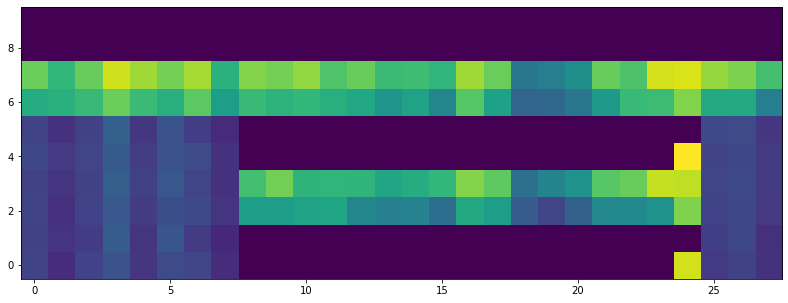

In [7]:
plt.figure(figsize=(20, 5))
plt.imshow(a, origin='lower')

In [13]:
hrrr = xr.open_mfdataset('/home/jupyter/data/hrrr//4km/total_precipitation/202001*.nc')

In [52]:
nmmb = xr.open_mfdataset('/home/jupyter/data/hiresw_conusnmmb///4km/total_precipitation/202001*.nc')
nmmbv2 = xr.open_mfdataset('/home/jupyter/data/hiresw_conusnmmb///4kmv2/total_precipitation/202001*.nc')

In [42]:
nssl = xr.open_mfdataset('/home/jupyter/data/hiresw_conusnssl///4km/total_precipitation/202001*.nc')

In [11]:
nam = xr.open_mfdataset('/home/jupyter/data/nam_conusnest/4km/total_precipitation/202001*.nc')
namv2 = xr.open_mfdataset('/home/jupyter/data/nam_conusnest/4kmv2/total_precipitation/202001*.nc')

In [57]:
xr.open_dataarray('/home/jupyter/data/hiresw_conusarw//4kmv3/total_precipitation/20200106_00.nc')

<xarray.DataArray 'tp' (init_time: 1, lead_time: 8, lat: 750, lon: 1376)>
[8256000 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        (lead_time) timedelta64[ns] ...
    surface     float64 ...
    valid_time  (lead_time) datetime64[ns] ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * init_time   (init_time) datetime64[ns] 2020-01-06
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04

In [58]:
xr.open_dataarray('/home/jupyter/data/hiresw_conusarw//4kmv3/total_precipitation/20200109_00.nc')

<xarray.DataArray 'tp' (init_time: 1, lead_time: 48, lat: 750, lon: 1376)>
[49536000 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        (lead_time) timedelta64[ns] ...
    surface     float64 ...
    valid_time  (lead_time) datetime64[ns] ...
  * lead_time   (lead_time) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
  * init_time   (init_time) datetime64[ns] 2020-01-09
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04

In [71]:
arw = xr.open_mfdataset('/home/jupyter/data/hiresw_conusarw//4km/total_precipitation/202001*.nc')
arwv2 = xr.open_mfdataset('/home/jupyter/data/hiresw_conusarw//4kmv2/total_precipitation/202001*.nc')
arwv3 = xr.open_mfdataset('/home/jupyter/data/hiresw_conusarw//4kmv3/total_precipitation/202001*.nc')

In [14]:
nam = nam.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
namv2 = namv2.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
hrrr = hrrr.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [53]:
nmmb = nmmb.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
nmmbv2 = nmmbv2.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [43]:
nssl = nssl.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [72]:
arw = arw.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
arwv2 = arwv2.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
arwv3 = arwv3.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [17]:
nam.load()
namv2.load()
hrrr.load()

<xarray.Dataset>
Dimensions:    (init_time: 62, lat: 750, lon: 1376)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2020-01-31T12:00:00
  * lon        (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0
  * lat        (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
Data variables:
    tp         (init_time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [73]:
arw.load()
arwv2.load()
arwv3.load();

In [54]:
nmmb.load();
nmmbv2.load()
nssl.load();

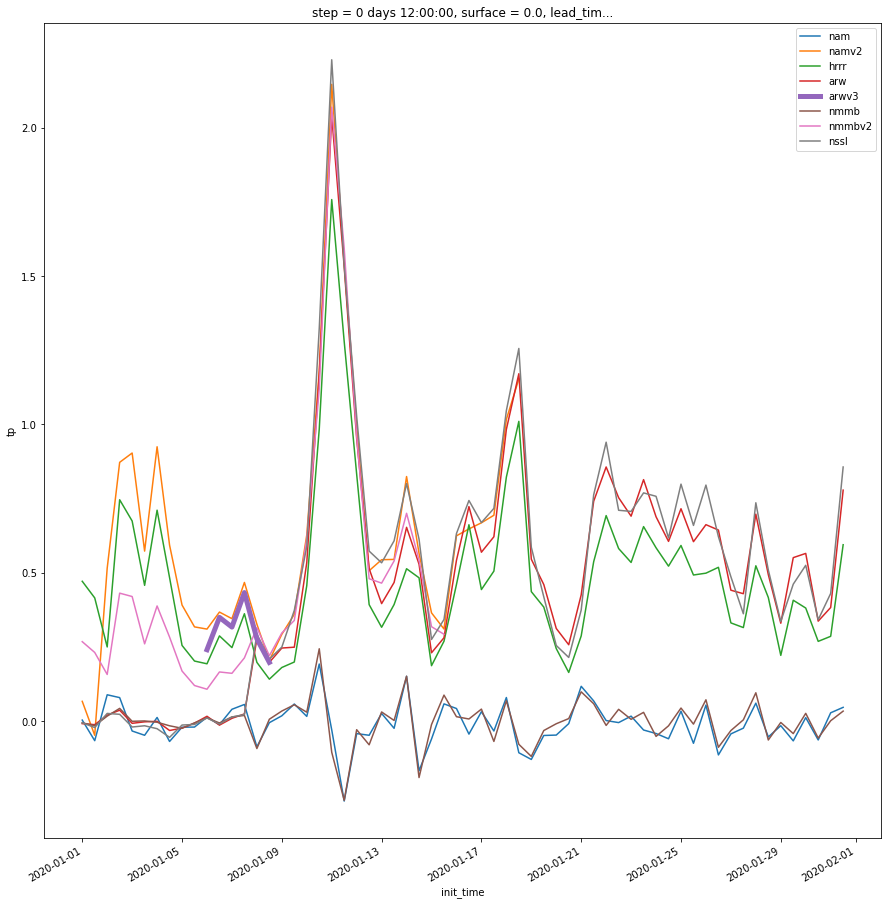

In [78]:
plt.figure(figsize=(15, 15))
nam.tp.mean(('lat', 'lon')).plot(label='nam')
(namv2.tp/2).mean(('lat', 'lon')).plot(label='namv2')
hrrr.tp.mean(('lat', 'lon')).plot(label='hrrr')
arw.tp.mean(('lat', 'lon')).plot(label='arw')
# arwv2.tp.mean(('lat', 'lon')).plot(label='arwv2')
arwv3.tp.mean(('lat', 'lon')).plot(label='arwv3', zorder=100, lw=5)
nmmb.tp.mean(('lat', 'lon')).plot(label='nmmb')
(nmmbv2.tp/2).mean(('lat', 'lon')).plot(label='nmmbv2')
nssl.tp.mean(('lat', 'lon')).plot(label='nssl')
plt.legend()

In [130]:
h = xr.open_dataarray('/home/jupyter/data/hrefv4//4km/total_precipitation/20200110_12.nc').load()

In [131]:
diff = h.diff('lead_time').mean(('lat', 'lon'))

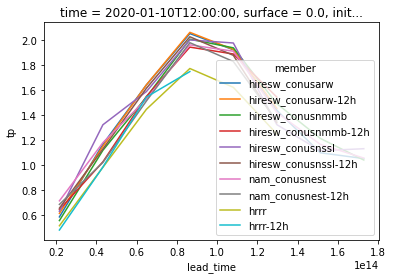

In [132]:
diff.plot(hue='member');

In [105]:
ratio = (diff / diff.sel(member='nam_conusnest')).mean('lead_time')

In [108]:
ratio < 1.8

<xarray.DataArray 'tp' (member: 10, init_time: 1)>
array([[ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])
Coordinates:
    time       datetime64[ns] 2020-01-10T12:00:00
    surface    float64 0.0
  * init_time  (init_time) datetime64[ns] 2020-01-10T12:00:00
  * member     (member) object 'hiresw_conusarw' ... 'hrrr-12h'

In [117]:
is_hrrr = ['hrrr' in m for m in ratio.member.values]

In [120]:
ratio[is_hrrr] = False

In [121]:
ratio

<xarray.DataArray 'tp' (member: 10, init_time: 1)>
array([[0.98602176],
       [0.9988602 ],
       [1.96306   ],
       [1.9504961 ],
       [1.0071237 ],
       [0.9817745 ],
       [1.        ],
       [0.9558258 ],
       [1.        ],
       [1.        ]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2020-01-10T12:00:00
    surface    float64 0.0
  * init_time  (init_time) datetime64[ns] 2020-01-10T12:00:00
  * member     (member) object 'hiresw_conusarw' ... 'hrrr-12h'

In [ ]:
href_old = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/2020010*.nc').load()

In [54]:
href_diff = href_old.diff('lead_time')

In [43]:
href_old.tp.sel(member='hiresw_conusarw').mean(('lat', 'lon'))

<xarray.DataArray 'tp' (init_time: 17, lead_time: 9)>
array([[0.        , 0.08631577, 0.07073513, 0.05563435, 0.09752359,
        0.11740693, 0.12164549, 0.12690571, 0.10575582],
       [0.        , 0.05053368, 0.06714078, 0.1260427 , 0.15488759,
        0.12952358, 0.10558359, 0.05844321, 0.08072978],
       [0.        , 0.10781136, 0.15049572, 0.13365124, 0.11074644,
        0.0526353 , 0.06962579, 0.12618083, 0.12662399],
       [0.        , 0.13931613, 0.13844286, 0.08197811, 0.07567222,
        0.12294276, 0.11327945, 0.11216757, 0.09901128],
       [0.        , 0.09093724, 0.09124745, 0.1294337 , 0.10933669,
        0.08496658, 0.07212345, 0.05670965, 0.05074337],
       [0.        , 0.12265738, 0.11864868, 0.08831339, 0.07260148,
        0.05679629, 0.04114883, 0.04276606, 0.03427921],
       [0.        , 0.09732721, 0.08133799, 0.05391039, 0.04414976,
        0.04997725, 0.0379823 , 0.02649185, 0.0189527 ],
       [0.        , 0.06638397, 0.04197615, 0.04366698, 0.03692093,
        0.02638809, 0.02478239, 0.04215122, 0.04319472],
       [0.        , 0.04341127, 0.03726933, 0.03200916, 0.03350408,
        0.04969548, 0.05004788, 0.04065406, 0.053799  ],
       [0.        , 0.03033711, 0.04099272, 0.05623412, 0.04784048,
        0.04212048, 0.05537812, 0.05001708, 0.07269161],
       [0.        , 0.0587714 , 0.05221554, 0.05363218, 0.06050514,
        0.06283552, 0.0700757 , 0.06058856, 0.03465935],
       [0.        , 0.04516492, 0.05910603, 0.06655686, 0.0852753 ,
        0.04915934, 0.0360989 , 0.02512993, 0.02885035],
       [0.        , 0.06160595, 0.0804857 , 0.04742498, 0.03075453,
        0.02074674, 0.02514433, 0.02904108, 0.02810087],
       [0.        , 0.23582505, 0.14310043, 0.09996248, 0.10701012,
        0.13759677, 0.14451647, 0.14306559, 0.17119102],
       [0.        , 0.10816651, 0.11425755, 0.12180702, 0.14589609,
        0.1366902 , 0.16846532, 0.21896893, 0.28116497],
       [0.        , 0.11185701, 0.14552893, 0.14634302, 0.18148217,
        0.2435047 , 0.27283826, 0.30776677, 0.51710296],
       [0.        , 0.1366655 , 0.1914909 , 0.2665141 , 0.2883658 ,
        0.28602692, 0.51567906, 0.8477726 , 0.8972748 ]], dtype=float32)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-01T12:00:00 ......
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    member      <U16 'hiresw_conusnmmb'

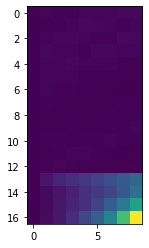

In [60]:
plt.imshow(href_old.tp.sel(member='hiresw_conusarw').mean(('lat', 'lon')))

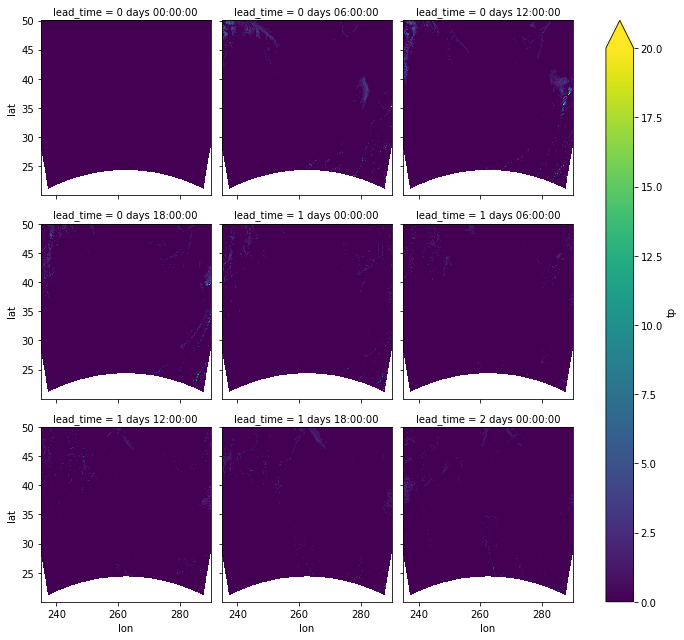

In [108]:
href_old.tp.sel(member='hiresw_conusnmmb').isel(init_time=12).plot(
    col='lead_time', col_wrap=3, vmin=0, vmax=20)

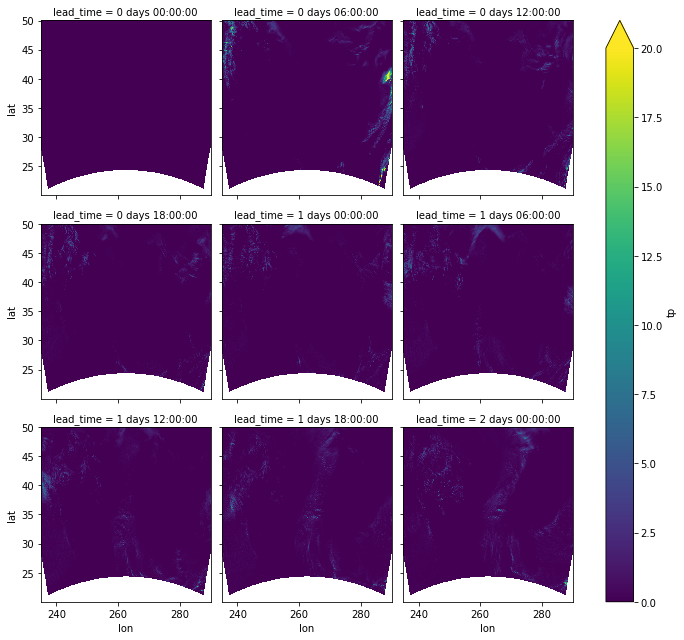

In [109]:
href_old.tp.sel(member='hiresw_conusnmmb').isel(init_time=13).plot(col='lead_time', col_wrap=3, vmin=0, vmax=20)

In [26]:
ds.href.sel(member='hrrr').max(), ds.href.sel(member='hrrr').min()

(<xarray.DataArray 'tp' ()>
 array(679.92980957)
 Coordinates:
     lead_time  timedelta64[ns] 12:00:00
     surface    float64 0.0
     member     <U4 'hrrr',
 <xarray.DataArray 'tp' ()>
 array(-0.01003265)
 Coordinates:
     lead_time  timedelta64[ns] 12:00:00
     surface    float64 0.0
     member     <U4 'hrrr')

In [12]:
da1 = xr.open_dataarray('/home/jupyter/data//nam_conusnest/rawv2/total_precipitation/20200602_00.nc')
da2 = xr.open_dataarray('/home/jupyter/data//hrrr/raw/total_precipitation/20200602_00.nc')

In [13]:
da1

<xarray.DataArray 'tp' (init_time: 1, lead_time: 8, y: 1059, x: 1799)>
[15241128 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
    step        (lead_time) timedelta64[ns] ...
    surface     float64 ...
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    valid_time  (lead_time) datetime64[ns] ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * init_time   (init_time) datetime64[ns] 2020-06-02
Dimensions without coordinates: y, x

In [14]:
da2

<xarray.DataArray 'tp' (init_time: 1, lead_time: 7, y: 1059, x: 1799)>
[13335987 values with dtype=float32]
Coordinates:
    lat        (y, x) float32 ...
    lon        (y, x) float32 ...
  * lead_time  (lead_time) timedelta64[ns] 00:00:00 06:00:00 ... 1 days 12:00:00
  * init_time  (init_time) datetime64[ns] 2020-06-02
Dimensions without coordinates: y, x

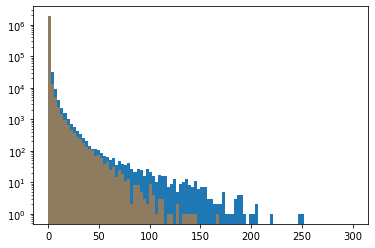

In [15]:
plt.hist(da1.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h')).values.flat, range=(0, 300), bins=100)
plt.hist(da2.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h')).values.flat, range=(0, 300), bins=100, alpha=0.5);
plt.yscale('log');

In [16]:
da1.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h')).max()

<xarray.DataArray 'tp' ()>
array(251.62991333)
Coordinates:
    time        datetime64[ns] 2020-06-02
    step        timedelta64[ns] 12:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2020-06-02T12:00:00
    lead_time   timedelta64[ns] 12:00:00

In [17]:
da2.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h')).max()

<xarray.DataArray 'tp' ()>
array(165.38615417)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00

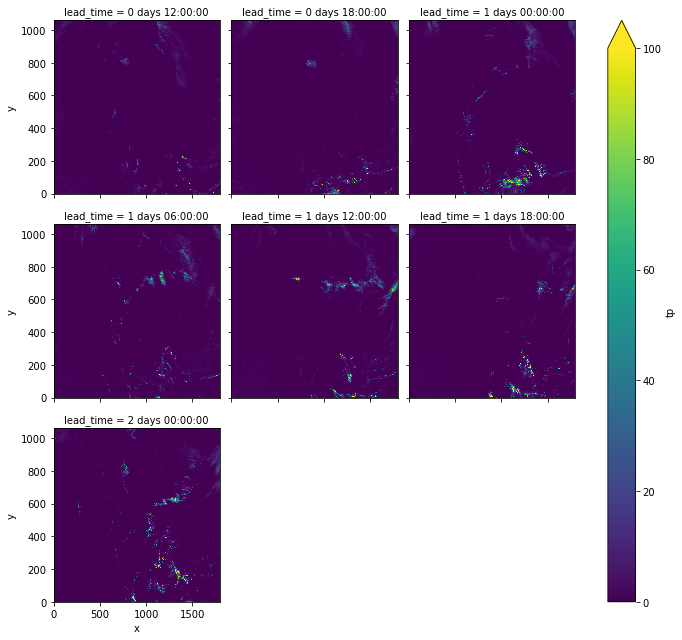

In [18]:
da1.diff('lead_time').plot(col='lead_time', col_wrap=3, vmin=0, vmax=100)

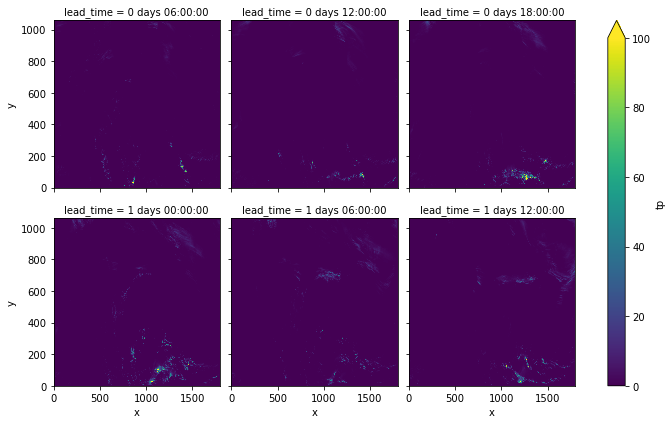

In [19]:
da2.diff('lead_time').plot(col='lead_time', col_wrap=3, vmin=0, vmax=100)

In [62]:
len(ds.idxs)

1080

In [57]:
len(ds.idxs)

1080

In [46]:
X, y, h = ds[0]

In [47]:
X.shape, y.shape, h.shape

((10, 16, 16), (1, 128, 128), (1, 10, 128, 128))

In [55]:
hrefmask = np.isfinite(ds.href).mean(('member', 'valid_time')) == 1

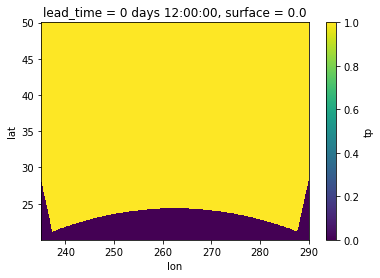

In [63]:
hrefmask.plot()

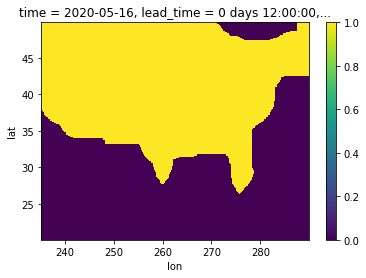

In [64]:
ds.rqmask.plot()

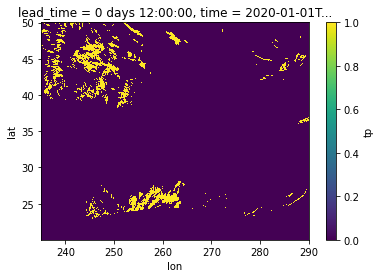

In [70]:
(ds.href < 0).isel(member=0, valid_time=0).plot()

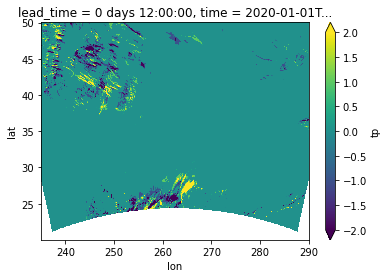

In [72]:
ds.href.isel(member=0, valid_time=0).plot(vmin=-2, vmax=2)

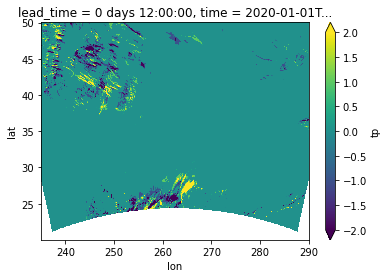

In [73]:
href.isel(member=0, valid_time=0).plot(vmin=-2, vmax=2)